In [32]:
import numpy as np
import numpy.matlib as mt
import h5py
import math 
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.trials import align_trials
from ephysvibe.task import task_constants

from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

import os 
from matplotlib import cm
from matplotlib import pyplot as plt
import glob
from pathlib import Path
import pickle

from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import permutations
seed = 2023


In [2]:
def moving_average(data:np.ndarray,win:int, step:int=1)-> np.ndarray:
    d_shape=data.shape
    d_avg = np.zeros((d_shape[0],int(np.floor(d_shape[1]/step))))
    d_zsc = np.zeros((d_shape[0],int(np.floor(d_shape[1]/step))))
    count = 0

    for i_step in np.arange(0, d_shape[1]-step, step):
        d_avg[:,count]  =   np.mean(data[:,i_step:i_step+win],axis=1)
        if np.std(d_avg[:,count])!=0:
            d_zsc[:,count]  =   (d_avg[:,count]-np.mean(d_avg[:,count]))/np.std(d_avg[:,count])
        count +=1

    return d_avg, d_zsc

In [ ]:
def compute_roc_auc(group1,group2):
    rng = np.random.default_rng(seed=seed)
    roc_score = []
    p = []
    for n_win in np.arange(group1.shape[1]):
        g1 = group1[:,n_win]
        g2 = group2[:,n_win]

        # Wilcoxon rank-sum 
        p.append(stats.ttest_ind(g1, g2)[1])#stats.ttest_ind

        thresholds = np.unique(np.concatenate([g1,g2]))

        y_g1, y_g2 = np.ones(len(g1)),np.zeros(len(g2))
        score=0.5
        fpr,tpr=[],[]
        for threshold in thresholds:
            g1_y_pred,g2_y_pred = np.zeros(len(g1)),np.zeros(len(g2))
            g1_mask,g2_mask = g1>=threshold,g2>=threshold
            g1_y_pred[g1_mask],g2_y_pred[g2_mask] = 1,1
            tp = sum(np.logical_and(y_g1==1,g1_y_pred==1))
            fn = sum(np.logical_and(y_g1==1,g1_y_pred==0))
            tpr.append(tp/ (tp+fn) )
            fp = sum(np.logical_and(y_g2==0,g2_y_pred==1))
            tn = sum(np.logical_and(y_g2==0,g2_y_pred==0))
            fpr.append(fp/ (fp+tn) )
        if len(fpr) > 1:
            fpr,tpr=np.array(fpr),np.array(tpr)
                      
            score = metrics.auc(fpr[fpr.argsort()],tpr[fpr.argsort()])
        roc_score.append(score)
        
    roc_score = np.array(roc_score)
    roc_score = scale_p(np.round(roc_score,2),out_range=[-1,1])
    return roc_score, p


In [3]:
with open('W:/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/LIP_test', 'rb') as handle:
    test_lip = pickle.load(handle)

# with open('W:/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/PFC_test', 'rb') as handle:
#     test_pfc = pickle.load(handle)
    
# with open('W:/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/averaged_structures/V4_test', 'rb') as handle:
#     test_v4 = pickle.load(handle)

In [33]:
model=  SVC(kernel='linear',C=1, decision_function_shape='ovr',gamma='auto',degree=1)

In [34]:
win=100
step=1
test_data_avg_sp, test_data_z_sp  =   moving_average(data=test_lip[0]['data'],win=win, step=step)

In [25]:
so1c1_to1c1     =   np.where(np.logical_and(test_lip[0]['test id']==11, test_lip[0]['sample id']==11))[0]
so1c5_to1c5     =   np.where(np.logical_and(test_lip[0]['test id']==15, test_lip[0]['sample id']==15))[0]
so5c1_to5c1     =   np.where(np.logical_and(test_lip[0]['test id']==51, test_lip[0]['sample id']==51))[0]
so5c5_to5c5     =   np.where(np.logical_and(test_lip[0]['test id']==55, test_lip[0]['sample id']==55))[0]

sother_to1c1     =   np.where(np.logical_and(test_lip[0]['test id']==11, test_lip[0]['sample id']!=11, test_lip[0]['sample id']!=0))[0]
sother_to1c5     =   np.where(np.logical_and(test_lip[0]['test id']==15, test_lip[0]['sample id']!=15, test_lip[0]['sample id']!=0))[0]
sother_to5c1     =   np.where(np.logical_and(test_lip[0]['test id']==51, test_lip[0]['sample id']!=51, test_lip[0]['sample id']!=0))[0]
sother_to5c5     =   np.where(np.logical_and(test_lip[0]['test id']==55, test_lip[0]['sample id']!=55, test_lip[0]['sample id']!=0))[0]


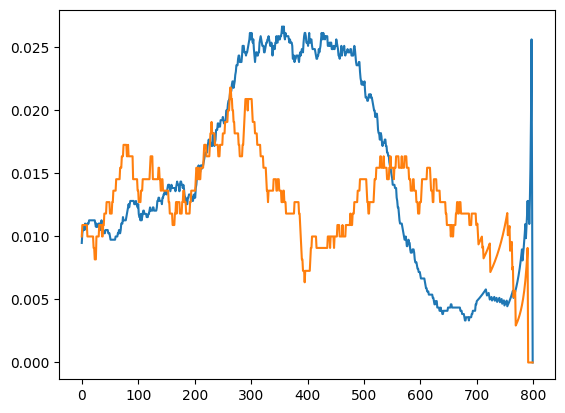

In [30]:
plt.plot(np.mean(test_data_avg_sp[so1c1_to1c1,:], axis=0))
plt.plot(np.mean(test_data_avg_sp[sother_to1c1,:], axis=0))

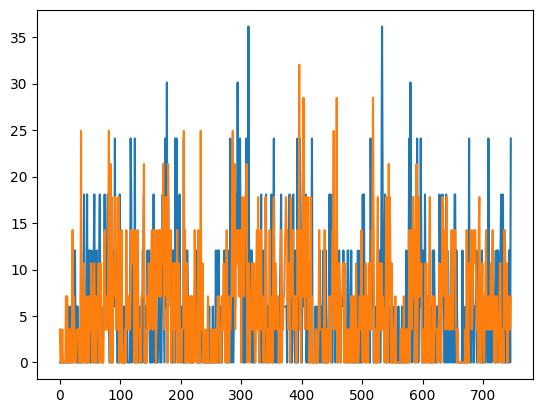

In [19]:


test_lip[0]['']


plt.plot(np.mean(test_lip[25]['data'][:,test_lip[25]['match trials']], axis=1)*1000)
plt.plot(np.mean(test_lip[25]['data'][:,test_lip[25]['nomatch_trials']], axis=1)*1000)


In [215]:
# test_o1_so1_trials  =   test_so1_trials[np.where((test_id_so1_trials/10).astype(int)==1)]
# test_o2_so1_trials  =   test_so1_trials[np.where((test_id_so1_trials/10).astype(int)==2)]
# test_o3_so1_trials  =   test_so1_trials[np.where((test_id_so1_trials/10).astype(int)==3)]
# test_o4_so1_trials  =   test_so1_trials[np.where((test_id_so1_trials/10).astype(int)==4)]
# test_o5_so1_trials  =   test_so1_trials[np.where((test_id_so1_trials/10).astype(int)==5)]
# test_o6_so1_trials  =   test_so1_trials[np.where((test_id_so1_trials/10).astype(int)==6)]
# test_o7_so1_trials  =   test_so1_trials[np.where((test_id_so1_trials/10).astype(int)==7)]
# test_o8_so1_trials  =   test_so1_trials[np.where((test_id_so1_trials/10).astype(int)==8)]

# test_o1_so5_trials  =   test_so5_trials[np.where((test_id_so5_trials/10).astype(int)==1)]
# test_o2_so5_trials  =   test_so5_trials[np.where((test_id_so5_trials/10).astype(int)==2)]
# test_o3_so5_trials  =   test_so5_trials[np.where((test_id_so5_trials/10).astype(int)==3)]
# test_o4_so5_trials  =   test_so5_trials[np.where((test_id_so5_trials/10).astype(int)==4)]
# test_o5_so5_trials  =   test_so5_trials[np.where((test_id_so5_trials/10).astype(int)==5)]
# test_o6_so5_trials  =   test_so5_trials[np.where((test_id_so5_trials/10).astype(int)==6)]
# test_o7_so5_trials  =   test_so5_trials[np.where((test_id_so5_trials/10).astype(int)==7)]
# test_o8_so5_trials  =   test_so5_trials[np.where((test_id_so5_trials/10).astype(int)==8)]

# test_c1_sc1_trials  =   test_sc1_trials[np.where((test_id_sc1_trials%10).astype(int)==1)]
# test_c2_sc1_trials  =   test_sc1_trials[np.where((test_id_sc1_trials%10).astype(int)==2)]
# test_c3_sc1_trials  =   test_sc1_trials[np.where((test_id_sc1_trials%10).astype(int)==3)]
# test_c4_sc1_trials  =   test_sc1_trials[np.where((test_id_sc1_trials%10).astype(int)==4)]
# test_n_sc1_trials   =   test_sc1_trials[np.where((test_id_sc1_trials%10).astype(int)==5)]
# test_c6_sc1_trials  =   test_sc1_trials[np.where((test_id_sc1_trials%10).astype(int)==6)]
# test_c7_sc1_trials  =   test_sc1_trials[np.where((test_id_sc1_trials%10).astype(int)==7)]
# test_c8_sc1_trials  =   test_sc1_trials[np.where((test_id_sc1_trials%10).astype(int)==8)]

# test_c1_sc5_trials  =   test_sc5_trials[np.where((test_id_sc5_trials%10).astype(int)==1)]
# test_c2_sc5_trials  =   test_sc5_trials[np.where((test_id_sc5_trials%10).astype(int)==2)]
# test_c3_sc5_trials  =   test_sc5_trials[np.where((test_id_sc5_trials%10).astype(int)==3)]
# test_c4_sc5_trials  =   test_sc5_trials[np.where((test_id_sc5_trials%10).astype(int)==4)]
# test_c5_sc5_trials  =   test_sc5_trials[np.where((test_id_sc5_trials%10).astype(int)==5)]
# test_c6_sc5_trials  =   test_sc5_trials[np.where((test_id_sc5_trials%10).astype(int)==6)]
# test_c7_sc5_trials  =   test_sc5_trials[np.where((test_id_sc5_trials%10).astype(int)==7)]
# test_c8_sc5_trials  =   test_sc5_trials[np.where((test_id_sc5_trials%10).astype(int)==8)]

# test_o1_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials/10).astype(int)==1)]
# test_o2_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials/10).astype(int)==2)]
# test_o3_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials/10).astype(int)==3)]
# test_o4_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials/10).astype(int)==4)]
# test_o5_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials/10).astype(int)==5)]
# test_o6_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials/10).astype(int)==6)]
# test_o7_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials/10).astype(int)==7)]
# test_o8_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials/10).astype(int)==8)]

# test_c1_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials%10).astype(int)==1)]
# test_c2_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials%10).astype(int)==2)]
# test_c3_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials%10).astype(int)==3)]
# test_c4_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials%10).astype(int)==4)]
# test_c5_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials%10).astype(int)==5)]
# test_c6_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials%10).astype(int)==6)]
# test_c7_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials%10).astype(int)==7)]
# test_c8_sn_trials   =   test_sn_trials[np.where((test_id_sn_trials%10).astype(int)==8)]

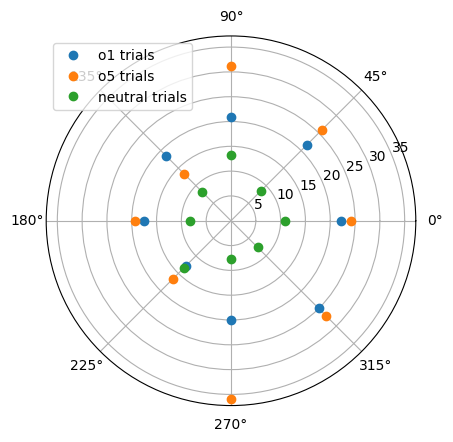

In [170]:
# plt.polar(np.linspace(0,math.pi*2,9)[:-1],[np.mean(test_data[test_o1_so1_trials,250:450]*1000),
#           np.mean(test_data[test_o2_so1_trials,250:450]*1000),
#           np.mean(test_data[test_o3_so1_trials,250:450]*1000),
#           np.mean(test_data[test_o4_so1_trials,250:450]*1000),
#           np.mean(test_data[test_o5_so1_trials,250:450]*1000),
#           np.mean(test_data[test_o6_so1_trials,250:450]*1000),
#           np.mean(test_data[test_o7_so1_trials,250:450]*1000),
#           np.mean(test_data[test_o8_so1_trials,250:450]*1000)], 'o')

# plt.polar(np.linspace(0,math.pi*2,9)[:-1],[np.mean(test_data[test_o1_so5_trials,250:450]*1000),
#           np.mean(test_data[test_o2_so5_trials,250:450]*1000),
#           np.mean(test_data[test_o3_so5_trials,250:450]*1000),
#           np.mean(test_data[test_o4_so5_trials,250:450]*1000),
#           np.mean(test_data[test_o5_so5_trials,250:450]*1000),
#           np.mean(test_data[test_o6_so5_trials,250:450]*1000),
#           np.mean(test_data[test_o7_so5_trials,250:450]*1000),
#           np.mean(test_data[test_o8_so5_trials,250:450]*1000)], 'o')

# plt.polar(np.linspace(0,math.pi*2,9)[:-1],[np.mean(test_data[test_o1_sn_trials,250:450]*1000),
#           np.mean(test_data[test_o2_sn_trials,250:450]*1000),
#           np.mean(test_data[test_o3_sn_trials,250:450]*1000),
#           np.mean(test_data[test_o4_sn_trials,250:450]*1000),
#           np.mean(test_data[test_o5_sn_trials,250:450]*1000),
#           np.mean(test_data[test_o6_sn_trials,250:450]*1000),
#           np.mean(test_data[test_o7_sn_trials,250:450]*1000),
#           np.mean(test_data[test_o8_sn_trials,250:450]*1000)], 'o')
# plt.legend(['o1 trials', 'o5 trials', 'neutral trials'])


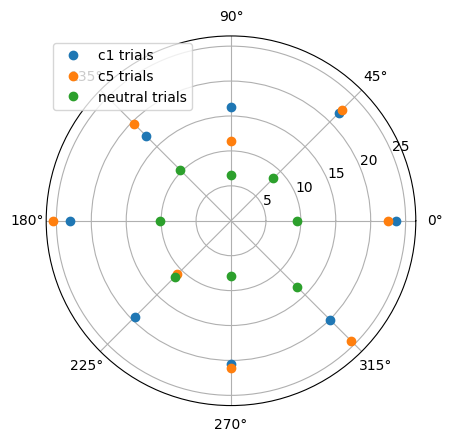

In [171]:
# plt.polar(np.linspace(0,math.pi*2,9)[:-1],[np.mean(test_data[test_c1_sc1_trials,250:450]*1000),
#           np.mean(test_data[test_c2_sc1_trials,250:450]*1000),
#           np.mean(test_data[test_c3_sc1_trials,250:450]*1000),
#           np.mean(test_data[test_c4_sc1_trials,250:450]*1000),
#           np.mean(test_data[test_c5_sc1_trials,250:450]*1000),
#           np.mean(test_data[test_c6_sc1_trials,250:450]*1000),
#           np.mean(test_data[test_c7_sc1_trials,250:450]*1000),
#           np.mean(test_data[test_c8_sc1_trials,250:450]*1000)], 'o')

# plt.polar(np.linspace(0,math.pi*2,9)[:-1],[np.mean(test_data[test_c1_sc5_trials,250:450]*1000),
#           np.mean(test_data[test_c2_sc5_trials,250:450]*1000),
#           np.mean(test_data[test_c3_sc5_trials,250:450]*1000),
#           np.mean(test_data[test_c4_sc5_trials,250:450]*1000),
#           np.mean(test_data[test_c5_sc5_trials,250:450]*1000),
#           np.mean(test_data[test_c6_sc5_trials,250:450]*1000),
#           np.mean(test_data[test_c7_sc5_trials,250:450]*1000),
#           np.mean(test_data[test_c8_sc5_trials,250:450]*1000)], 'o')

# plt.polar(np.linspace(0,math.pi*2,9)[:-1],[np.mean(test_data[test_c1_sn_trials,250:450]*1000),
#           np.mean(test_data[test_c2_sn_trials,250:450]*1000),
#           np.mean(test_data[test_c3_sn_trials,250:450]*1000),
#           np.mean(test_data[test_c4_sn_trials,250:450]*1000),
#           np.mean(test_data[test_c5_sn_trials,250:450]*1000),
#           np.mean(test_data[test_c6_sn_trials,250:450]*1000),
#           np.mean(test_data[test_c7_sn_trials,250:450]*1000),
#           np.mean(test_data[test_c8_sn_trials,250:450]*1000)], 'o')
# plt.legend(['c1 trials', 'c5 trials', 'neutral trials'])


In [173]:
# win=100
# step=1
# test_data_avg_sp, test_data_z_sp  =   moving_average(data=test_data,win=win, step=step)



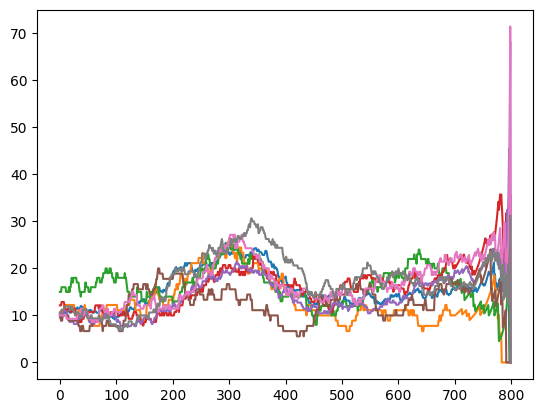

In [180]:
# plt.plot(np.mean(test_data_avg_sp[test_o1_so1_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o2_so1_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o3_so1_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o4_so1_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o5_so1_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o6_so1_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o7_so1_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o8_so1_trials,:], axis=0)*1000)

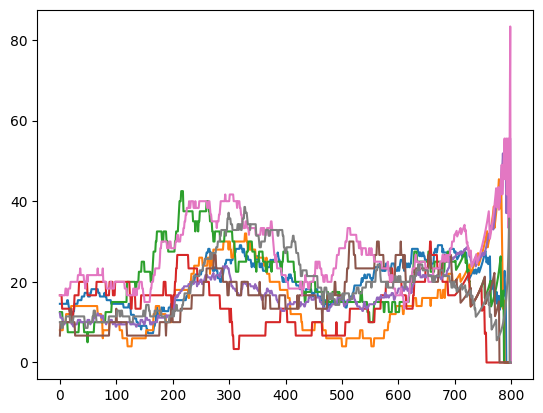

In [181]:
# plt.plot(np.mean(test_data_avg_sp[test_o1_so5_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o2_so5_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o3_so5_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o4_so5_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o5_so5_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o6_so5_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o7_so5_trials,:], axis=0)*1000)
# plt.plot(np.mean(test_data_avg_sp[test_o8_so5_trials,:], axis=0)*1000)

In [220]:
# so1c1_to1c1     =   np.where(np.logical_and(test_id==11, sample_id==11))[0]
# so1c5_to1c5     =   np.where(np.logical_and(test_id==15, sample_id==15))[0]
# so5c1_to5c1     =   np.where(np.logical_and(test_id==51, sample_id==51))[0]
# so5c5_to5c5     =   np.where(np.logical_and(test_id==55, sample_id==55))[0]

# sother_to1c1     =   np.where(np.logical_and(test_id==11, sample_id!=11, sample_id!=0))[0]
# sother_to1c5     =   np.where(np.logical_and(test_id==15, sample_id!=15, sample_id!=0))[0]
# sother_to5c1     =   np.where(np.logical_and(test_id==51, sample_id!=51, sample_id!=0))[0]
# sother_to5c5     =   np.where(np.logical_and(test_id==55, sample_id!=55, sample_id!=0))[0]


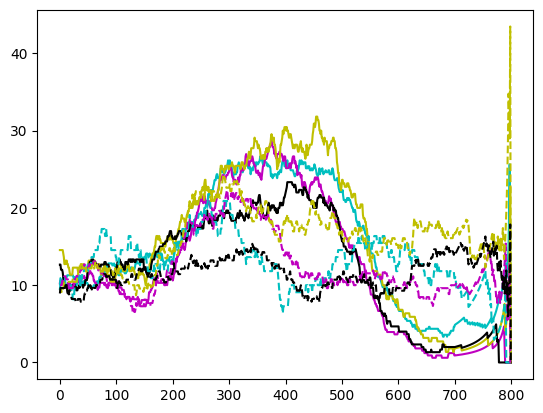

In [227]:

# plt.plot(np.mean(test_data_avg_sp[so1c1_to1c1,:], axis=0)*1000, color='c')
# plt.plot(np.mean(test_data_avg_sp[so1c5_to1c5,:], axis=0)*1000, color='m')
# plt.plot(np.mean(test_data_avg_sp[so5c1_to5c1,:], axis=0)*1000, color='y')
# plt.plot(np.mean(test_data_avg_sp[so5c5_to5c5,:], axis=0)*1000, color='k')

# plt.plot(np.mean(test_data_avg_sp[sother_to1c1,:], axis=0)*1000, color='c', linestyle='dashed')
# plt.plot(np.mean(test_data_avg_sp[sother_to1c5,:], axis=0)*1000, color='m', linestyle='dashed')
# plt.plot(np.mean(test_data_avg_sp[sother_to5c1,:], axis=0)*1000, color='y', linestyle='dashed')
# plt.plot(np.mean(test_data_avg_sp[sother_to5c5,:], axis=0)*1000, color='k', linestyle='dashed')
